# Lung Segmentation


## import all packages



In [1]:
import os
import datetime
import time
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization,MaxPooling2D,Dense,concatenate
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate,Conv2DTranspose
from tensorflow.keras.layers import Input,UpSampling3D,Dense, Dropout,BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.metrics import Recall, Precision,MeanIoU,AUC
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model



/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
IMAGE_SIZE = 256
EPOCHS = 50
BATCH = 4
LR = 1e-4

PATH = './dataset/LSP/train/'

# Load dataset

In [4]:
def load_data(path='../dataset/LSP/train/', split=0.1,mode=''):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))
    
    if mode == 'training':
        total_size = len(images)
        valid_size = int(split * total_size)
        train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
        train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

        return (train_x, train_y), (valid_x, valid_y)
    
    if mode == 'testing':
        return (images,masks)

In [5]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [6]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([256, 256, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
#     dataset = dataset.repeat()
    return dataset


In [7]:
(train_x, train_y), (valid_x, valid_y) = load_data(PATH,mode='training')

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))


Training data:  1359
Validation data:  150


In [8]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

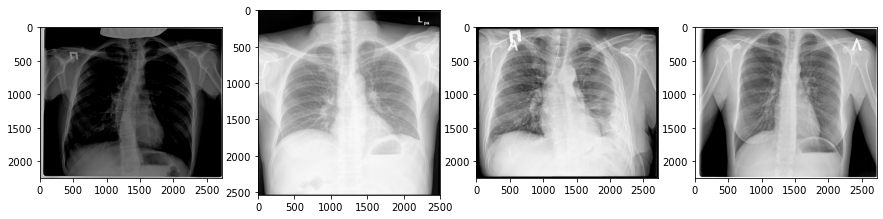

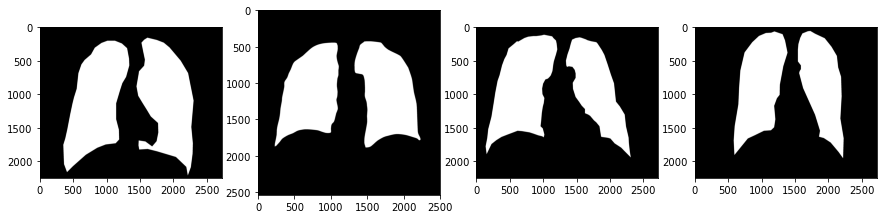

In [9]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(valid_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(valid_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(valid_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(valid_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(valid_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(valid_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(valid_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(valid_y[3]))
imgplot.set_clim(0.0, 1.4)

## load pretrained model from tensorflow 

In [10]:
def build_model(inputs):
    mobilenetv2 = tf.keras.applications.MobileNetV2(
        input_tensor = inputs, 
        weights="imagenet", include_top=False, alpha=0.35)
    mobilenetv2.trainable = False
    x = mobilenetv2.get_layer('out_relu').output
    x = Conv2D(128,3,name='final_conv',padding='same',activation='relu')(x)
    x = GlobalAveragePooling2D(name='gap')(x)
    output = Dense(2,activation='sigmoid')(x)
    return tf.keras.Model(inputs,output)


# build unet from the pretrained model 

https://github.com/nikhilroxtomar/Unet-with-Pretrained-Encoder/blob/master/U-Net_with_Pretrained_MobileNetV2_as_Encoder.ipynb?ref=morioh.com&utm_source=morioh.com

![image](https://github.com/nikhilroxtomar/Unet-with-Pretrained-Encoder/raw/5898a1e1ee66df875239d679839a30e419b20375//images/u-net-architecture.png)

In [11]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = build_model(inputs)
#     encoder.load_weights('../../output/checkpoints/mobilenetv2/512_128weights.16-0.31.hdf5')
    skip_connection_names = ["input_image","block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    f = [ 16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    
    return model

![image](https://miro.medium.com/max/700/1*PqtyWOC9StSUBFw1SLMe4g.png)

In [25]:
# def unet_plus_plus():
#     return

In [12]:
model = model()
model.summary()

Metal device set to: Apple M1


2022-08-18 08:17:06.910029: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-18 08:17:06.910110: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 16) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

## Define Evaluatoin Metrics

In [13]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def jackard_index(y_true, y_pred):
    
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) -intersection + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [14]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)


In [15]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, jackard_index, AUC(curve='PR'), Recall(), Precision()]
model.load_weights('./output/unet_weights.17.0.04.hdf5')
model.compile(loss = dice_loss, optimizer=opt, metrics=metrics)


In [16]:
log_dir = "logs/unet/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
    ModelCheckpoint(
        './output/unet_weights.{epoch:02d}.{val_loss:.2f}.hdf5',
        monitor='val_loss',save_best_only=True,save_weights_only=True,verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

2022-08-18 08:17:07.720814: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-08-18 08:17:07.720823: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-08-18 08:17:07.720906: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [17]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=20,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
2022-08-18 08:17:07.950841: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-18 08:17:07.950954: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20


2022-08-18 08:17:09.099742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


  1/340 [..............................] - ETA: 13:33 - loss: 0.0249 - dice_coef: 0.9751 - jackard_index: 0.9515 - auc: 0.9883 - recall: 0.9718 - precision: 0.9843

2022-08-18 08:17:10.414505: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-08-18 08:17:10.414521: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  2/340 [..............................] - ETA: 1:44 - loss: 0.0243 - dice_coef: 0.9757 - jackard_index: 0.9525 - auc: 0.9878 - recall: 0.9739 - precision: 0.9828 

2022-08-18 08:17:10.666500: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-18 08:17:10.671673: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-08-18 08:17:10.676812: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/unet/20220818-081707/train/plugins/profile/2022_08_18_08_17_10
2022-08-18 08:17:10.679062: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/unet/20220818-081707/train/plugins/profile/2022_08_18_08_17_10/users-MacBook-Pro.local.trace.json.gz
2022-08-18 08:17:10.684545: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/unet/20220818-081707/train/plugins/profile/2022_08_18_08_17_10
2022-08-18 08:17:10.684749: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/unet/20220818-081707/train/plugins/

340/340 [==============================] - ETA: 0s - loss: 0.0303 - dice_coef: 0.9697 - jackard_index: 0.9414 - auc: 0.9780 - recall: 0.9711 - precision: 0.9751

2022-08-18 08:19:09.123594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


340/340 [==============================] - 135s 390ms/step - loss: 0.0303 - dice_coef: 0.9697 - jackard_index: 0.9414 - auc: 0.9780 - recall: 0.9711 - precision: 0.9751 - val_loss: 0.0450 - val_dice_coef: 0.9547 - val_jackard_index: 0.9140 - val_auc: 0.9543 - val_recall: 0.9772 - val_precision: 0.9411

Epoch 00001: val_loss improved from inf to 0.04501, saving model to ./output/unet_weights.01.0.05.hdf5
Epoch 2/20
340/340 [==============================] - 131s 385ms/step - loss: 0.0275 - dice_coef: 0.9725 - jackard_index: 0.9466 - auc: 0.9777 - recall: 0.9726 - precision: 0.9771 - val_loss: 0.0332 - val_dice_coef: 0.9664 - val_jackard_index: 0.9352 - val_auc: 0.9697 - val_recall: 0.9686 - val_precision: 0.9694

Epoch 00002: val_loss improved from 0.04501 to 0.03319, saving model to ./output/unet_weights.02.0.03.hdf5
Epoch 3/20
340/340 [==============================] - 130s 383ms/step - loss: 0.0262 - dice_coef: 0.9738 - jackard_index: 0.9490 - auc: 0.9772 - recall: 0.9732 - precision

In [18]:
test_x, test_y= load_data(path='./dataset/LSP/test/',mode='testing')
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

print("test data: ", len(test_x))
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
    

test data:  138


In [19]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x


In [20]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask


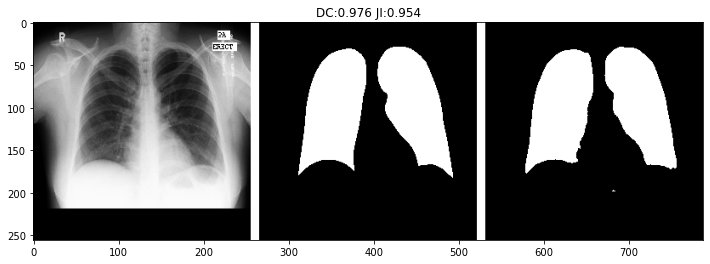

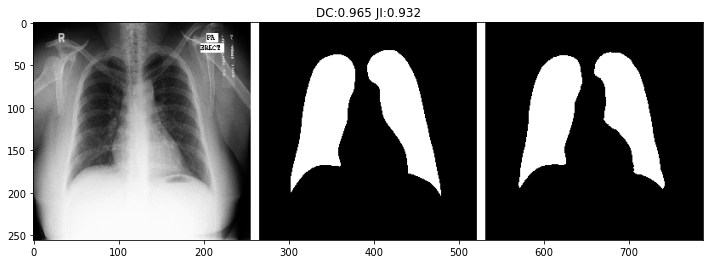

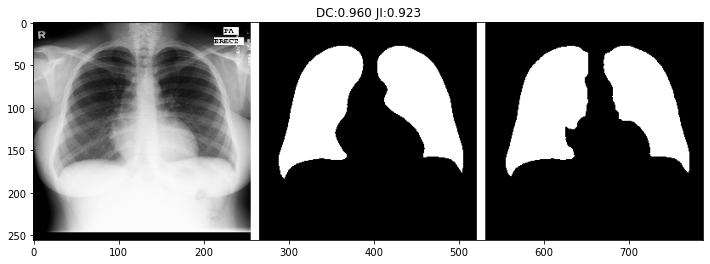

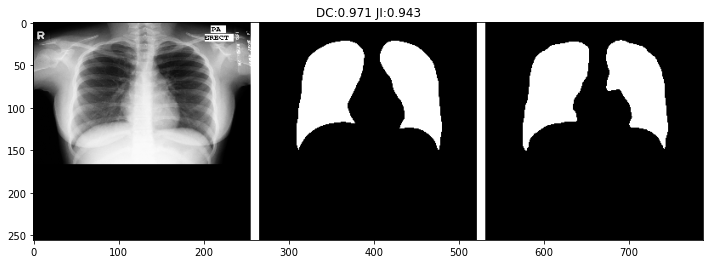

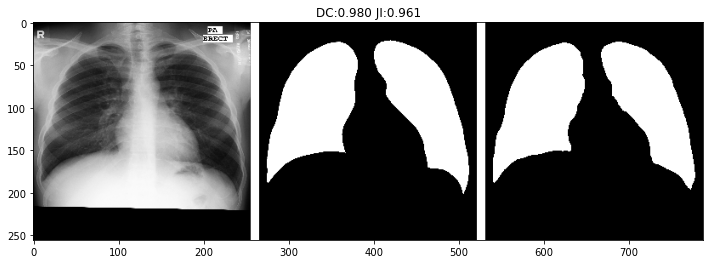

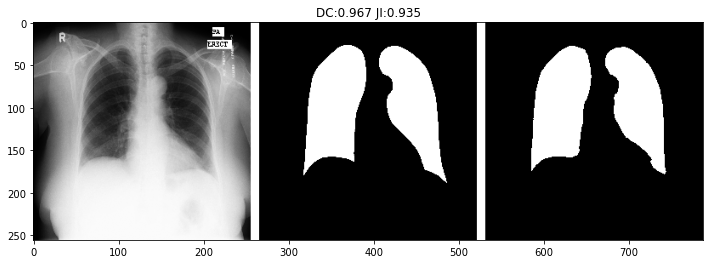

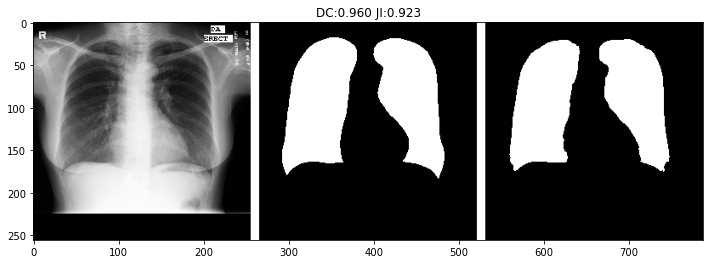

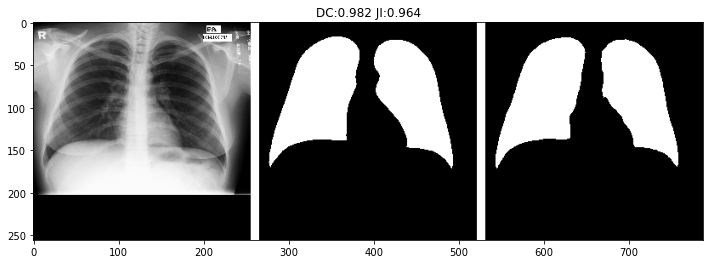

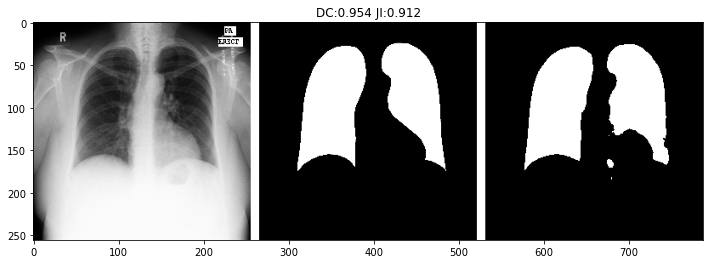

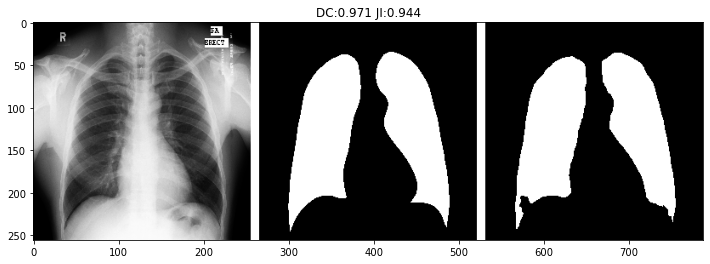

In [23]:
for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image(x)
    y = read_mask(y)
    
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    yp = np.where(y_pred == True, 1.0, 0.0)
    fig = plt.figure(figsize=(12, 12)) 
    a = fig.add_subplot(1, 1, 1)
    a.axes.set_title('DC:{:.3f} JI:{:.3f}'.format(dice_coef(y,yp),jackard_index(y,yp)))
    imgplot = plt.imshow(image)
    
    

In [24]:
dicecoef=0
jackardindex=0
for  i, (x, y) in enumerate(zip(test_x, test_y)):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    yp = np.where(y_pred == True, 1.0, 0.0)
    

    dicecoef += dice_coef(y,yp)
    jackardindex += jackard_index(y,yp)
    
print('DC:{:.3f} JI:{:.3f}'.format(dicecoef/138,jackardindex/138))

DC:0.967 JI:0.937
